# EECS 16A: OMP Demo

v1 - Fall 19: Neelesh Ramachandran

This demo is designed to give you some intuition into the process of OMP. In the code block starting with 'PARAMETER: change at will', you have the opportunity to toggle some parameters: whether shifting of the codes is on, how many codes to use, their length, and more! Currently, each iteration of the OMP algorithm is split into a separate code block. You may wish to compress this into a for loop (number of iterations is proportional to the number of codes) if you increase the code count. Enjoy, and feel free to reach out with feedback as well!

Some more info: If a particular code block doesn't run (or seems not to do anything), that's likely since the OMP algorithm has reached `n` iterations already.

Parameters:  
    `shifting_on`: True if codes can be shifted, False if not. False by default.
    `l`: length of each code.
    `n`: number of codes.  
    `lower` and `upper`: range of values for each code (can be overridden by hardcoded params below).  
    `hardcoded_dict_code_vals`: Empty by default. Add values to ensure that only values from the list are chosen as code values. If not empty, overrides `lower` and `upper`.  
    `hardcoded_ysig_code_weights`: Empty by default. If not empty, the received signal will no longer be randomly generated and will instead be composed of the codes weighted as described. For example,  if `hardcoded_ysig_code_weights` = [100, 0, 2], `y` will be comprised of 100(code1) + 2(code3).  
    `force_plot_codes`: False by default. Basically, plots for codes and cross-correlation start to become squished together and illegible if `n` and `l` are high; this attempts to avoid that. Unlikely to need to be changed.  
    

In [1]:
%pylab inline
import numpy as np
import csv
from scipy import linalg
import matplotlib.pyplot as plt
import random
plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def least_squares(A, b):
    return np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

In [3]:
# create n codes of length l, with lower and upper limits
def gen_code(n, l, lower, upper, hardcoded_list_code_vals):
    x = []
    if len(hardcoded_list_code_vals) == 0:
        for i in range(n):
            x.append(np.random.randint(lower, upper, size=l))
        return x;
    else:
        for i in range(n):
            x.append(np.random.choice(hardcoded_list_code_vals, l))
        return x;

In [4]:
# generate some arbitrary y using the codes and randomized weights!
#returns y and the "solutions" for weights of codes and shifts
def generate_y_and_solutions(codes, shifting_on, hardcoded_ysig_code_weights):
    y = np.zeros(l)
    code_weights, code_shifts = np.zeros(n), np.zeros(n) # use as answer key for comparison at the end!
    if len(hardcoded_ysig_code_weights) == 0:
        if shifting_on:
            for i in range(n):
                code_weights[i] = np.random.randint(-30, 30)/10
                code_shifts[i] = int(np.random.randint(0, l))
                codes[i] = np.roll(codes[i], int(code_shifts[i]))
                y += (code_weights[i])*codes[i]
        else: 
            for i in range(n):
                code_weights[i] = np.random.randint(-30, 30)/10
                y += (code_weights[i])*codes[i]
        return (y, code_weights, code_shifts)
    else:
        if len(hardcoded_ysig_code_weights) < n:
            hardcoded_ysig_code_weights.extend(np.zeros(n-len(hardcoded_ysig_code_weights)))
            print(hardcoded_ysig_code_weights)
        for i in range(n):
            y += hardcoded_ysig_code_weights[i] * codes[i]
        return (y, hardcoded_ysig_code_weights, code_shifts)

In [5]:
def make_pretty_plots(y, l, n, codes, lower, upper, plot_codes, force_plot_codes):
    if plot_codes or force_plot_codes:
        plt.figure(figsize=(24, 6))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.stem(np.arange(0, l), codes[i],use_line_collection=True)
            plt.xlim([-0.5, l-0.5])
            plt.ylim([lower-1, upper])
            plt.ylabel("Amplitude")
            plt.xlabel("Time Step")
            plt.title("Code {}".format(i+1))
    else:
        print("Plots ommitted for aesthetics, turn `force_plot_codes` to True if you want to see them anyways!")
        
    plt.figure(figsize=(8, 4))
    plt.stem(np.arange(0, l), y,use_line_collection=True)
    plt.xlabel("(Combined) Amplitude")
    plt.ylabel("Time Step")
    plt.title("Received Signal y")

    plt.show()

In [6]:
def make_pretty_code_plots(l, n, codes, lower, upper, plot_codes, force_plot_codes):
    if plot_codes or force_plot_codes:
        plt.figure(figsize=(24, 6))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.stem(np.arange(0, l), codes[i],use_line_collection=True)
            plt.xlim([-0.5, l-0.5])
            plt.ylim([lower-1, upper])
            plt.ylabel("Amplitude")
            plt.xlabel("Time Step")
            plt.title("Code {}".format(i+1))

    plt.show()

In [7]:
# From here on, we can only use y (or err) and the source codes to find the weights and shifts!
# compute cross correlations of y (or err) with all songs
def correlations(vec, codes, iter_count, shifting_on):
    corrs = np.zeros((n, l))
    if shifting_on:
        for i in range(n):
            for lag in range(l):
                corrs[i][lag] = np.correlate(vec, np.roll(codes[i], lag))

        plt.figure(figsize=(24, 6))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.stem(np.arange(0, l), corrs[i],use_line_collection=True)
            plt.ylabel("Correlation")
            plt.xlabel("Lag (Time Steps)")
            if iter_count == 1:
                plt.title("Cross Correlation: y with code {}".format(i+1))
            else:
                plt.title("Cross Correlation: err with code {}".format(i+1))

        plt.show()
    else:
        for i in range(n):
            for lag in np.zeros(l):
                corrs[i][int(lag)] = np.correlate(vec, np.roll(codes[i], int(lag)))
        
        curr_corrs = []
        for i in range(n):
            curr_corrs.append(corrs[i][0])
    
        plt.figure(figsize=(24, 6))
        xint = range(1,n+1)

        plt.xticks(xint)
        plt.stem(np.arange(1, n+1), curr_corrs,use_line_collection=True)
        plt.ylabel("Correlation", fontsize=20)
        plt.xlabel("Code Number", fontsize=20)
        if iter_count == 1:
            plt.title("Cross Correlation: y with codes")
        else:
            plt.title("Cross Correlation: err with codes")

        plt.show()
    return corrs

In [8]:
# Find index of max correlation (or simply the code with max corr, if unshifted)
# returns 3-tuple: max_val, code_num, index
def process_corrs(corrs):
    temp_corrs = np.abs(corrs)
    max_val = np.amax(temp_corrs)
    for i in range(n):
        if max_val in temp_corrs[i]:
            index = np.argmax(temp_corrs[i])
            code_num = i+1
    return (max_val, code_num, index)

In [9]:
# least_squares things with A_mat and recieved signal y, uses info = max_val, code_num, index
# returns weights, current_guess
def lst_sq_processing(A_mat, y, max_val, codes, code_num, index, prev_weights, iter_count):
    if (iter_count == 1):
        A_mat = np.roll(codes[code_num-1], index)
        weights = (1/(A_mat.T.dot(A_mat)))*(A_mat.T).dot(y)
        current_guess = np.array(A_mat * weights)
    else:
        A_mat = np.column_stack((A_mat, np.roll(codes[code_num-1], int(index))))
        weights = least_squares(A_mat, y)
        current_guess = np.array(A_mat @ weights)
    
    plt.figure()
    plt.stem(np.arange(0, l), current_guess,use_line_collection=True)

    markerline, stemlines, baseline = plt.stem(
        np.arange(0, l), y, linefmt='grey', markerfmt='D', use_line_collection=True)
    markerline.set_markerfacecolor('orange')
    markerline.set_markeredgecolor('orange')
    markerline.set_fillstyle('full')
    plt.stem(np.arange(0, l), y, linefmt='grey', markerfmt='D',use_line_collection=True)
    
    plt.ylabel("Amplitude")
    plt.xlabel("Time Step")
    
    plt.legend(("Original Received Signal (y)", "Current reconstruction"))
    
    if iter_count == 1:
        plt.title("Best approximation after {} iteration".format(iter_count))
    else:
        plt.title("Best approximation after {} iterations".format(iter_count))
    
    return (weights, current_guess, A_mat)

In [10]:
def will_this_be_pretty(l, n):
    plot_codes = False
    if n > 8:
        return plot_codes
    if (l < 30 and n < 5) or (l < 90 and n < 4) or (l < 150 and n < 3): 
        plot_codes = True
            
    return plot_codes

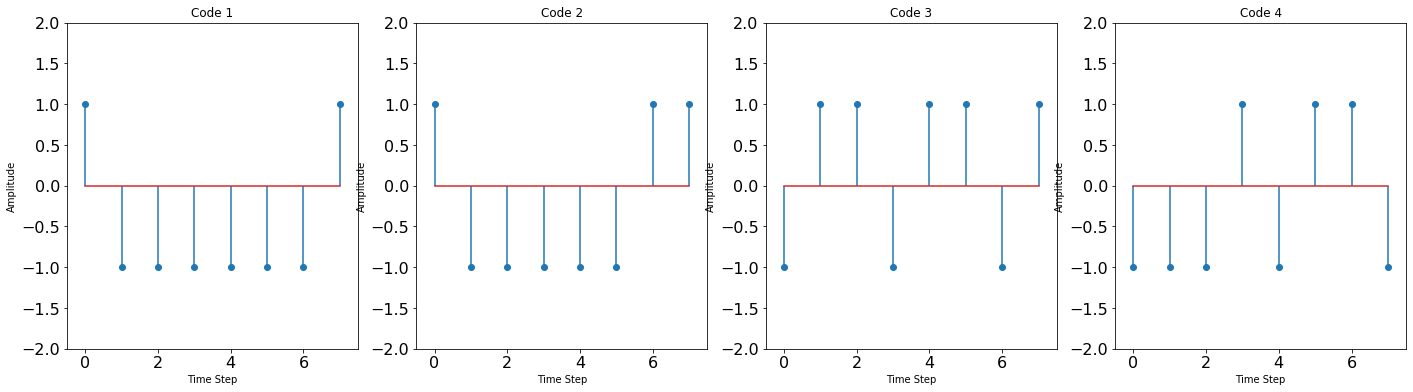

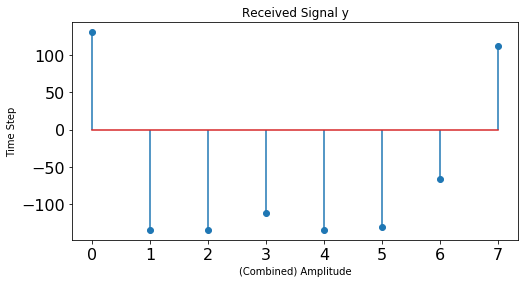

In [11]:
## PARAMETERS: Change below at will ###
shifting_on = False

l = 8
n = 4

lower= -1 # bounds for code values
upper = 1

hardcoded_dict_code_vals = [] # default
hardcoded_ysig_code_weights = [] # default

### overrides the above
### NOTE: comment out these two lines below to allow fully randomized generation of received signal and full range of lower -> upper for code vals
hardcoded_dict_code_vals = [1, -1] # set to include valid code values
hardcoded_ysig_code_weights = [100, 23, -9, 2] # rig the received signal (any weight not explicitly mentioned will be set to zero)

force_plot_codes = False # only change to True if you don't care too much about aesthetics in 
                         # plotting the generated codes :)
    
### PARAMETERS: Change the above at will ###

plot_codes = will_this_be_pretty(l, n)

codes = gen_code(n, l, lower, upper+1, hardcoded_dict_code_vals)
y, code_weights, code_shifts = generate_y_and_solutions(codes, shifting_on, hardcoded_ysig_code_weights)
# print(code_weights)
# print(y)
# print(codes[0])
# print(codes[1])
make_pretty_plots(y, l, n, codes, lower, upper+1, plot_codes, force_plot_codes)

***Iteration count:  1 ***


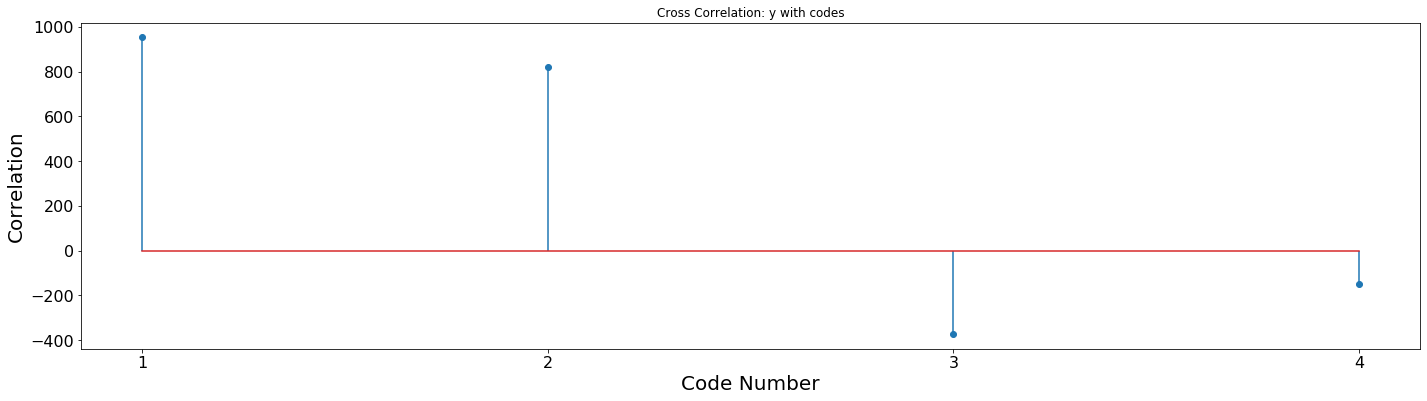

maxval: 952.0 codenumber: 1
Least squares weights: 119.0


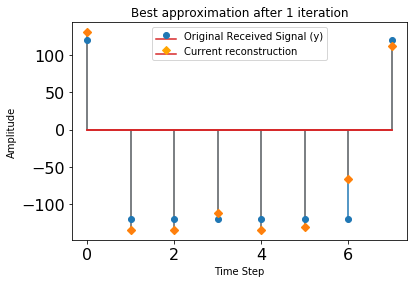

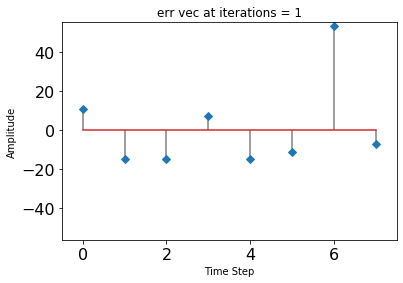

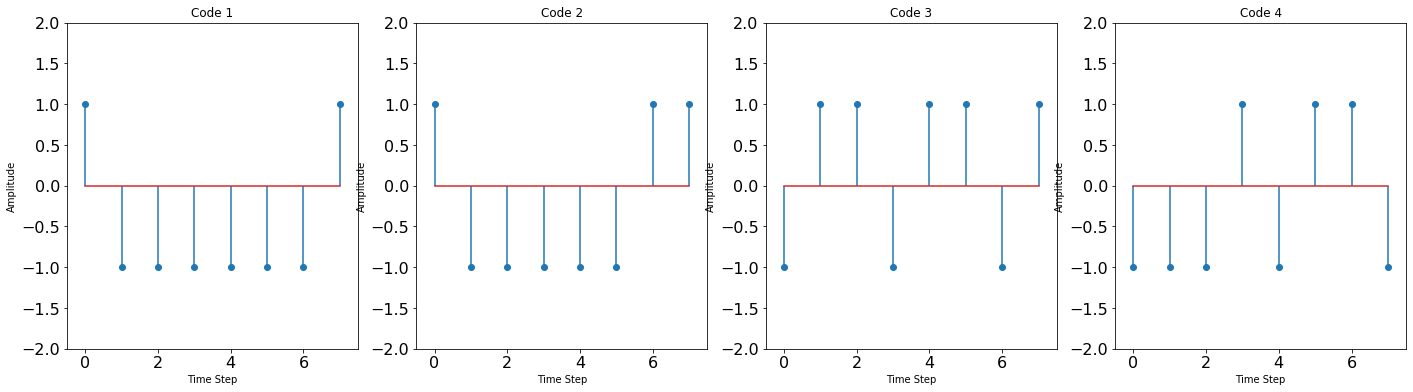

In [12]:
#Iteration 1

err = y
A_mat = np.zeros(l)
code_order = []
weights = 0
shifts = np.zeros(n)
scale_max = 0
counter = 0
if ((np.linalg.norm(err) > 0.001) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
    
    print("maxval:", max_val, "codenumber:", code_num)
    #print("maxval:", max_val, "codenumber:", code_num, "index:", index)
    
    code_order.append(code_num)
    
    # this is only used if there are delays in the transmissions
    shifts[code_num-1] = index
    
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess
    print("Least squares weights:", weights)
    
    ## Code for making figures
    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    
    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.ylabel("Amplitude")
    plt.xlabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()
    

    make_pretty_code_plots(l, n, codes, lower, upper+1, plot_codes, force_plot_codes)
    

***Iteration count:  2 ***


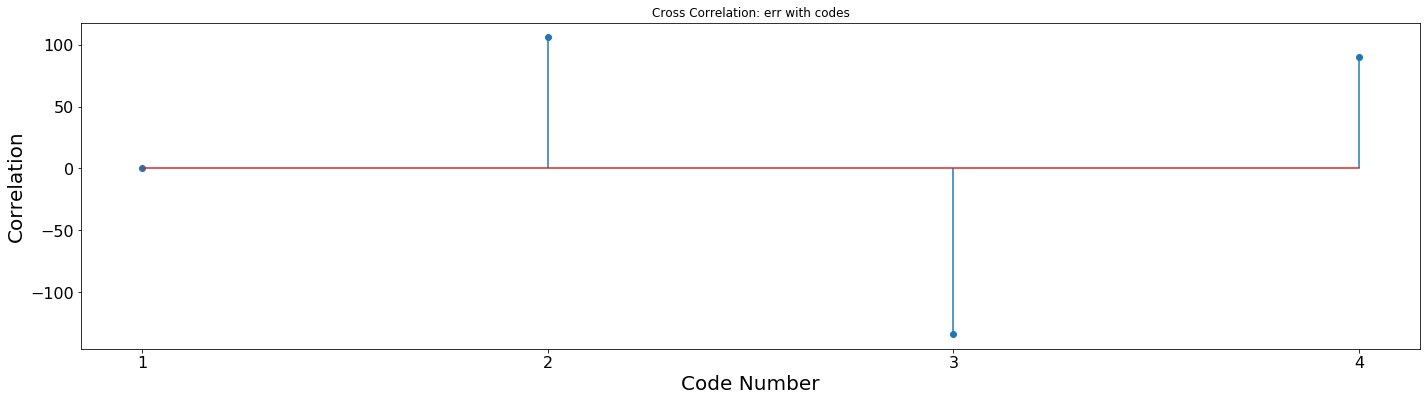

maxval: 134.0 codenumber: 3
Least squares weights: [114.53333333 -17.86666667]


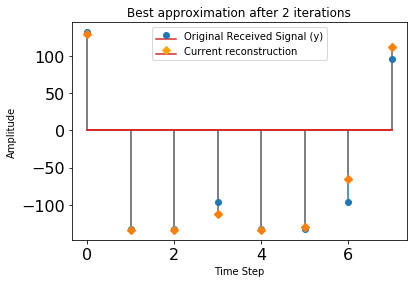

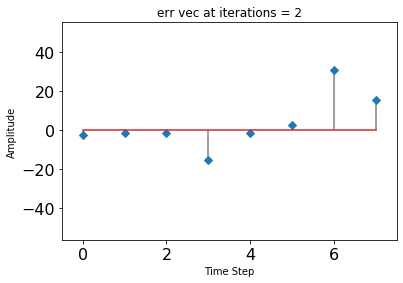

In [13]:
#Iteration 2
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 

    #     print("info: ", max_val, code_num, index)
    print("maxval:", max_val, "codenumber:", code_num)
    
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess
    print("Least squares weights:", weights)


    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.ylabel("Amplitude")
    plt.xlabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

***Iteration count:  3 ***


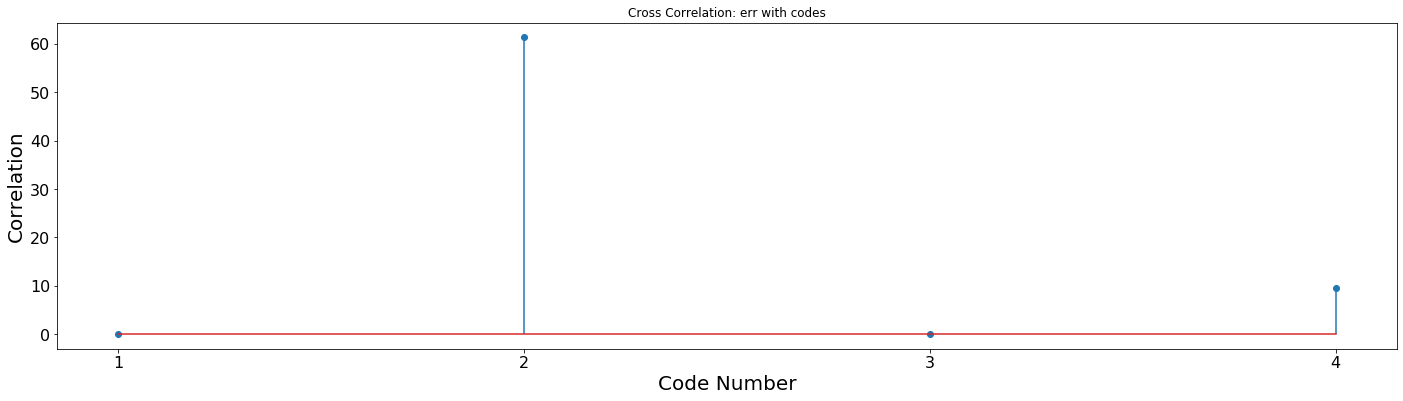

maxval: 61.333333333333314 codenumber: 2
Least squares weights: [ 99.2 -10.2  23. ]


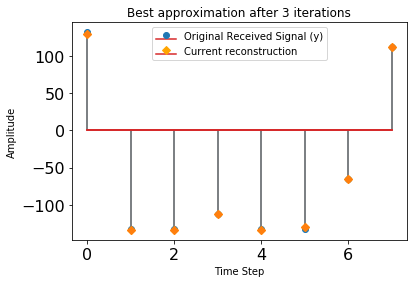

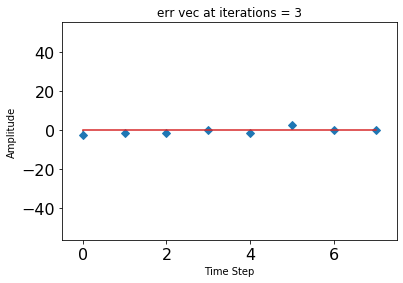

In [14]:
#Iteration 3
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
#     print("info: ", max_val, code_num, index)
    print("maxval:", max_val, "codenumber:", code_num)
    
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess
    print("Least squares weights:", weights)

    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.ylabel("Amplitude")
    plt.xlabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

***Iteration count:  4 ***


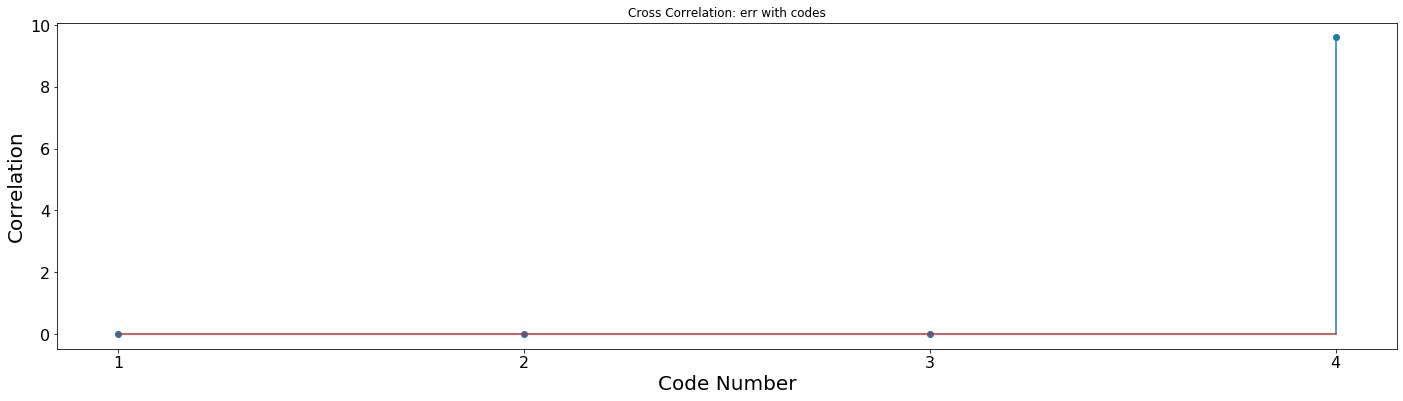

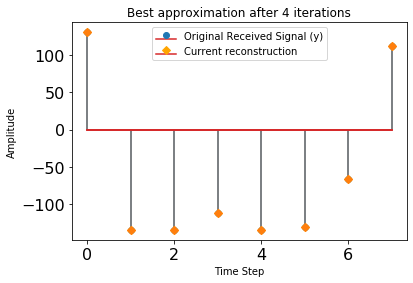

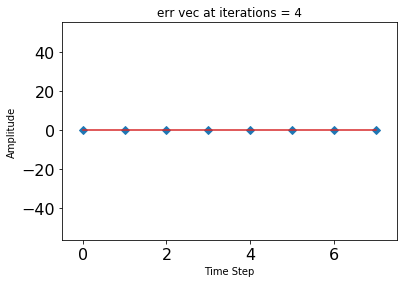

In [15]:
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
#     print("info: ", max_val, code_num, index)
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess

    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.ylabel("Amplitude")
    plt.xlabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

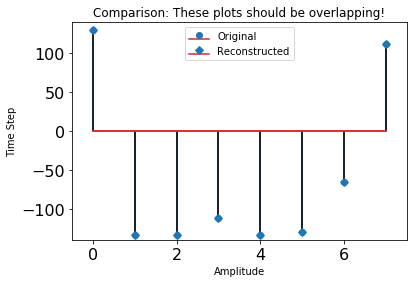

code weights:  [100, 23, -9, 2]
weights:  [100.  -9.  23.   2.]


In [16]:
#plot reconstructed signal alongside y
result_mine = np.zeros(l)
for i in range(n):
    if not isinstance(weights, type(0.4)) and len(weights) > i:
        val = np.multiply(weights[i], np.roll(codes[code_order[i]-1], int(shifts[code_order[i]-1])))
        result_mine += val

plt.figure()

plt.stem(np.arange(0, l), y, use_line_collection=True)

plt.stem(np.arange(0, l), result_mine, linefmt='black', markerfmt='D', use_line_collection=True)

plt.xlim([-0.5, l-0.5])
plt.ylim([(-np.abs(max(np.amax(y), np.amax(result_mine))))-10, (np.abs(max(np.amax(y), np.amax(result_mine))))+10])
plt.xlabel("Amplitude")
plt.ylabel("Time Step")
plt.legend(("Original", "Reconstructed"))
plt.title("Comparison: These plots should be overlapping!")

plt.show()

# print("code weights: ", code_weights)
# print("weights: ", weights)